In [149]:
from xcube.obs import open_zarr
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np

%matplotlib inline


In [224]:
ds = open_zarr('dcs4cop-obs-01/OLCI-SNS-RAW-CUBE-2.zarr', endpoint_url='http://obs.eu-de.otc.t-systems.com')

In [225]:
ds

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 1000, lon: 2000, time: 216)
Coordinates:
  * lat            (lat) float64 52.5 52.5 52.49 52.49 52.49 52.49 52.48 ...
    lat_bnds       (lat, bnds) float64 dask.array<shape=(1000, 2), chunksize=(1000, 2)>
  * lon            (lon) float64 0.00125 0.00375 0.00625 0.00875 0.01125 ...
    lon_bnds       (lon, bnds) float64 dask.array<shape=(2000, 2), chunksize=(2000, 2)>
  * time           (time) datetime64[ns] 2016-11-24T09:43:16.372487168 ...
    time_bnds      (time, bnds) datetime64[ns] dask.array<shape=(216, 2), chunksize=(1, 2)>
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<shape=(216, 1000, 2000), chunksize=(1, 1000, 2000)>
    conc_chl       (time, lat, lon) float64 dask.array<shape=(216, 1000, 2000), chunksize=(1, 1000, 2000)>
    conc_tsm       (time, lat, lon) float64 dask.array<shape=(216, 1000, 2000), chunksize=(1, 1000, 2000)>
    kd489          (time, lat, lon) f

In [236]:
ds.indexes['lat'].get_indexer([51.5])

TypeError: get_indexer() got an unexpected keyword argument 'lat'

In [239]:
dir(ds.conc_chl.loc)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'data_array']

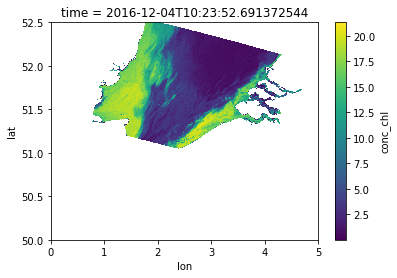

In [226]:
ds.conc_chl.isel(time=9).plot.imshow()

In [227]:
ds.conc_tsm.sel(time='2017-09-12', method='nearest')

<xarray.DataArray 'conc_tsm' (time: 2, lat: 1000, lon: 2000)>
dask.array<shape=(2, 1000, 2000), dtype=float64, chunksize=(1, 1000, 2000)>
Coordinates:
  * lat      (lat) float64 52.5 52.5 52.49 52.49 52.49 52.49 52.48 52.48 ...
  * lon      (lon) float64 0.00125 0.00375 0.00625 0.00875 0.01125 0.01375 ...
  * time     (time) datetime64[ns] 2017-09-12T10:12:46.061968384 ...
Attributes:
    long_name:               Total suspended matter dry weight concentration
    units:                   g m^-3
    valid_pixel_expression:  c2rcc_flags.Valid_PE

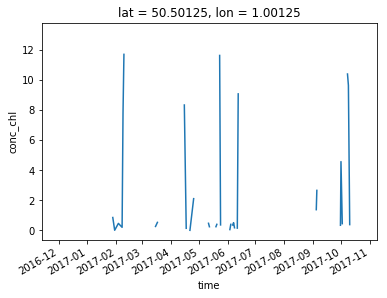

In [164]:
ds.conc_chl.sel(lon=1., lat=50.5, method='nearest').plot()

In [165]:
ds_resampled = ds.resample(time='7d',skipna = True, keep_attrs=True).mean()

C:\Users\gunnar\Miniconda3\envs\xcube-dev\lib\site-packages\dask\array\numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


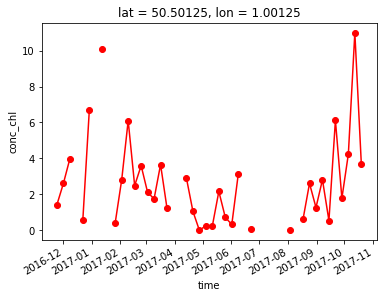

In [166]:
ds_resampled.conc_chl.sel(lon=1., lat=50.5, method='nearest').plot.line('r-o')

C:\Users\gunnar\Miniconda3\envs\xcube-dev\lib\site-packages\dask\array\numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


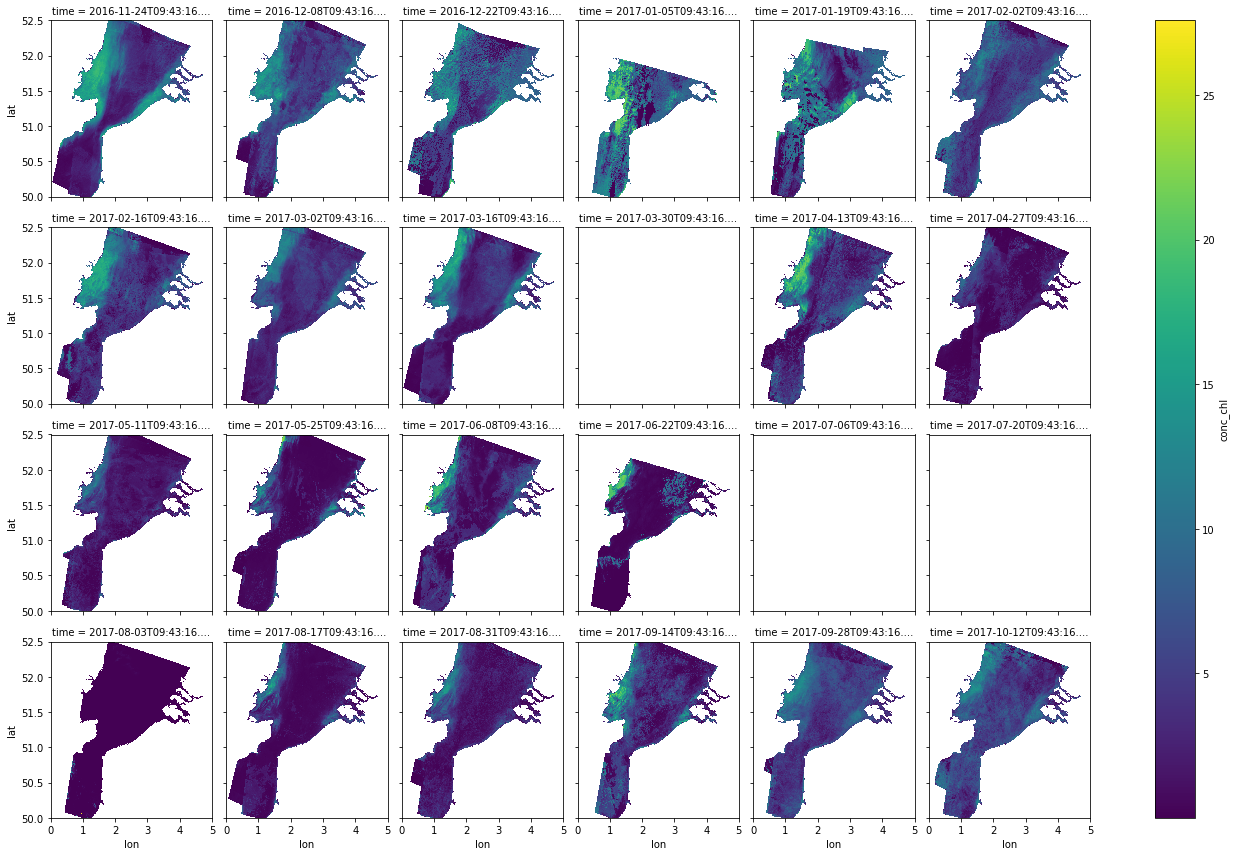

In [168]:
ds_daily = ds.resample(time='14d',skipna = True, keep_attrs=True).mean()
ds_daily.conc_chl.plot.imshow(x='lon',y='lat',col='time',col_wrap=6)

C:\Users\gunnar\Miniconda3\envs\xcube-dev\lib\site-packages\dask\array\numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


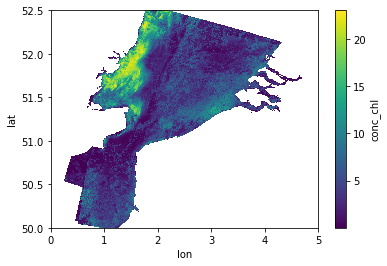

In [10]:
ds.conc_chl.mean(dim='time').plot.imshow()

In [169]:
ds_zscore = (ds-ds.mean(dim='time'))/ds.std(dim='time')

C:\Users\gunnar\Miniconda3\envs\xcube-dev\lib\site-packages\dask\array\reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
C:\Users\gunnar\Miniconda3\envs\xcube-dev\lib\site-packages\dask\array\numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


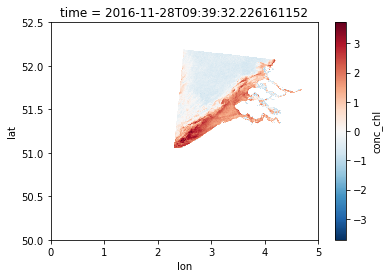

In [170]:
ds_zscore.conc_chl.isel(time=2).plot.imshow()

In [171]:
def above_Nsigma(x,Nsigma):
    return xr.ufuncs.fabs(x)>Nsigma

In [172]:
x_sigma =ds_zscore.apply(above_Nsigma,Nsigma = 1)

C:\Users\gunnar\Miniconda3\envs\xcube-dev\lib\site-packages\dask\array\reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
C:\Users\gunnar\Miniconda3\envs\xcube-dev\lib\site-packages\dask\array\numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gunnar\Miniconda3\envs\xcube-dev\lib\site-packages\dask\local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
C:\Users\gunnar\Miniconda3\envs\xcube-dev\lib\site-packages\dask\local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


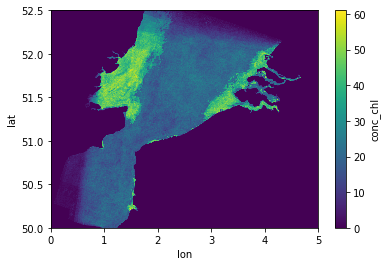

In [173]:
x_sigma.conc_chl.sum(dim="time",skipna = True).plot()

C:\Users\gunnar\Miniconda3\envs\xcube-dev\lib\site-packages\dask\array\numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(-1, 5)

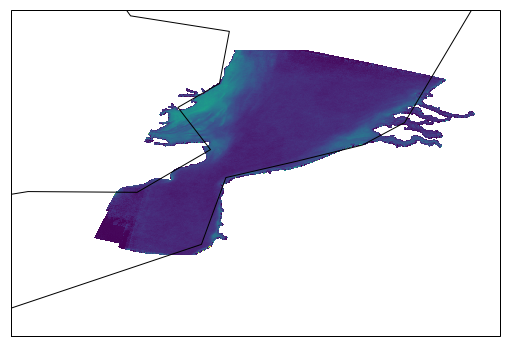

In [174]:
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds.conc_chl.mean(dim='time').plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False)
ax.coastlines()
ax.set_ylim([49,53])
ax.set_xlim([-1,5])

# Match-up

In [203]:
d = {'lat': np.random.uniform(low=51.5, high=52.5, size = 10), 'lon': np.random.uniform(low=2., high=3., size = 10), 'time': ['2017-01-01 10:12','2017-02-16 09:23','2017-06-18 12:34','2017-08-19 11:11','2017-11-28 08:34','2017-01-01 10:12','2017-02-16 09:23','2017-06-18 12:34','2017-08-19 11:11','2017-11-28 08:34'], 'CHL': np.random.uniform(low=0., high=32., size = 10) }

In [204]:
insitu = pd.DataFrame(d)

In [205]:
insitu.time = pd.to_datetime(insitu.time)

In [190]:
#def match_up(x, xa):
#    return xa.sel(lat=x.lat, lon=x.lon, time=x.time ,method = 'nearest')

In [209]:
# insitu.apply(match_up, axis = 1, args = ds_daily.conc_chl)

In [206]:
insitu['CHL_SAT'] = ds_daily.conc_chl.sel_points(lat = insitu.lat.values, lon = insitu.lon.values, time = insitu.time.values,method = "nearest")

C:\Users\gunnar\Miniconda3\envs\xcube-dev\lib\site-packages\dask\array\numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


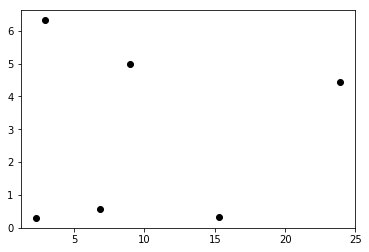

In [208]:
plt.plot(insitu.CHL,insitu.CHL_SAT,'ko')